# Benchmarking Data Normalization Methods with the Dexamethasone Benchmarking Resource (Limma Version)

This notebook reads in designated meta data and RNA-seq expression data files from a dexamethasone study and performs three normalization methods - counts per million (CPM), log transformation, and quantile normalization - on the data.

After differential gene analysis and enrichment analysis, the normalization methods are compared based on the NR3C1 transcription factor, a known target of dexamethasone. 

The code for limma and some normalization methods are adapted from the Bulk RNA-seq Analysis pipeline appyter: https://appyters.maayanlab.cloud/Bulk_RNA_seq/

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from IPython.display import display
import warnings
import json
import requests
import time
import scipy.stats as ss
from qnorm import quantile_normalize

from rpy2 import robjects
from rpy2.robjects import r, pandas2ri
pandas2ri.activate()

In [22]:
%load_ext rpy2.ipython

In [ ]:
%%R
install.packages("BiocManager")
BiocManager::install("limma")
BiocManager::install("edgeR")

# Load in Data

Using data from GEO from the study, "The effect of lithium and dexamethasone on fetal rat metatarsal bones transcriptome" 
https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE186104 

In [2]:
# Set all variables
meta_class_column_name = 'Sample_characteristics_ch1'
control_name = 'treatment: standard cultivation medium'
treatment = 'treatment: standard cultivation medium + dexamethason'
meta_data_filename = 'GSE186104_series_matrix.txt'
rnaseq_data_filename = 'GSE186104_cross_tabulation_of_gene_expression.txt'
low_expression_threshold = 0.3

In [3]:
# Load in data
try:
    meta_df = pd.read_csv(meta_data_filename, sep="\t", index_col=0, dtype=str)
except:
    print("Error! Please load a metadata file in txt or tsv format")
try:
    expr_df = pd.read_csv(rnaseq_data_filename, index_col=0, sep="\t").sort_index()
except:
    print("Error! Please load a RNA-seq expression file in txt or tsv format")
meta_df.index = meta_df.index.map(str)

# Match samples between the metadata and the datasets
if meta_class_column_name not in meta_df.columns:
    print(f"Error! Column '{meta_class_column_name}' is not in metadata")
    
meta_df = meta_df[meta_df.index.isin(expr_df.columns)]

# sort metadata by class labels; control first
classes = list(meta_df[meta_class_column_name].unique())
classes.remove(control_name)
classes.insert(0, control_name)
meta_df['tmp_class'] = pd.Categorical(meta_df[meta_class_column_name], classes)
meta_df = meta_df.sort_values('tmp_class')
meta_df = meta_df.drop('tmp_class', axis=1)
expr_df = expr_df.loc[:,meta_df.index]
expr_df = expr_df.groupby(expr_df.index).sum()
try:
    assert(meta_df.shape[0]==expr_df.shape[1])
except:
    print("Error! Input files are in a wrong format.")

dataset = dict()
current_dataset = 'rawdata'
dataset[current_dataset] = expr_df
dataset['dataset_metadata'] = meta_df

In [4]:
## Filter out non-expressed genes
expr_df = expr_df.loc[expr_df.sum(axis=1) > 0, :]
## Filter out lowly expressed genes
mask_low_vals = (expr_df > low_expression_threshold).sum(axis=1) > 2
expr_df = expr_df.loc[mask_low_vals, :]
current_dataset += '+filter_genes'
dataset[current_dataset] = expr_df

In [5]:
# Display meta data
meta_df

,Sample_title,Sample_characteristics_ch1
Sample_geo_accession,,
GSM5632354,C1: Untreated control replicate 1,treatment: standard cultivation medium
GSM5632355,C2: Untreated control replicate 2,treatment: standard cultivation medium
GSM5632356,C3: Untreated control replicate 3,treatment: standard cultivation medium
GSM5632357,Dex1: Dexamethason treated sample replicate 1,treatment: standard cultivation medium + dexam...
GSM5632358,Dex2: Dexamethason treated sample replicate 2,treatment: standard cultivation medium + dexam...
GSM5632359,Dex3: Dexamethason treated sample replicate 3,treatment: standard cultivation medium + dexam...


In [6]:
# Display expression data
expr_df

Sample_geo_accession,GSM5632354,GSM5632355,GSM5632356,GSM5632357,GSM5632358,GSM5632359
gene,,,,,,
A1i3,160,60,196,328,274,287
A2m,32,15,19,62,65,36
A3galt2,80,36,75,68,70,47
A4galt,0,0,2,0,1,2
Aaas,541,306,506,295,298,209
...,...,...,...,...,...,...
l7Rn6,392,199,385,174,185,142
mrpl11,374,218,233,144,192,133
mrpl24,611,344,560,222,316,222


# Normalization Methods

### CPM Normalization

In [7]:
# Define function for CPM
def CPM(data):
  with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    data = (data/data.sum())*10**6
    data = data.fillna(0)
  return data

In [17]:
# Perform CPM and display results
dataset['cpm'] = CPM(expr_df)
dataset['cpm']

Sample_geo_accession,GSM5632354,GSM5632355,GSM5632356,GSM5632357,GSM5632358,GSM5632359
gene,,,,,,
A1i3,7.288723,5.575553,9.766711,32.616120,23.449715,30.985142
A2m,1.457745,1.393888,0.946773,6.165242,5.562889,3.886638
A3galt2,3.644362,3.345332,3.737262,6.761879,5.990803,5.074222
A4galt,0.000000,0.000000,0.099660,0.000000,0.085583,0.215924
Aaas,24.644996,28.435319,25.214059,29.334620,25.503705,22.564093
...,...,...,...,...,...,...
l7Rn6,17.857372,18.492250,19.184610,17.302454,15.832837,15.330628
mrpl11,17.037391,20.257841,11.610426,14.319272,16.431917,14.358968
mrpl24,27.833812,31.966502,27.904888,22.075545,27.044197,23.967601


### Log Transformation

In [9]:
# Define function for log transformation
def log(data):

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        data = data.fillna(0)
        data = np.log2(data+1)
        
    return data

In [10]:
# Display log transformation results
dataset['log_transform'] = log(expr_df)
dataset['log_transform']

Sample_geo_accession,GSM5632354,GSM5632355,GSM5632356,GSM5632357,GSM5632358,GSM5632359
gene,,,,,,
A1i3,7.330917,5.930737,7.622052,8.361944,8.103288,8.169925
A2m,5.044394,4.000000,4.321928,5.977280,6.044394,5.209453
A3galt2,6.339850,5.209453,6.247928,6.108524,6.149747,5.584963
A4galt,0.000000,0.000000,1.584963,0.000000,1.000000,1.584963
Aaas,9.082149,8.262095,8.985842,8.209453,8.224002,7.714246
...,...,...,...,...,...,...
l7Rn6,8.618386,7.643856,8.592457,7.451211,7.539159,7.159871
mrpl11,8.550747,7.774787,7.870365,7.179909,7.592457,7.066089
mrpl24,9.257388,8.430453,9.131857,7.800900,8.308339,7.800900


### Quantile Normalization

In [11]:
# Define function for quantile normalization
def qnormalization(data):
  
    X_quantile_norm = quantile_normalize(data)
    return X_quantile_norm

In [12]:
# Perform and display quantile normalization results
dataset['quantile_norm'] = qnormalization(expr_df)
dataset['quantile_norm']

Sample_geo_accession,GSM5632354,GSM5632355,GSM5632356,GSM5632357,GSM5632358,GSM5632359
gene,,,,,,
A1i3,98.716667,81.090476,137.397436,465.511905,322.712963,440.666667
A2m,19.883333,21.168067,13.462046,87.938095,75.261261,57.358491
A3galt2,48.935484,48.470588,52.659420,96.030303,80.606667,74.316239
A4galt,0.000000,0.271847,1.448500,0.255986,1.011297,3.220286
Aaas,337.333333,399.622222,354.562500,417.178571,351.000000,322.863636
...,...,...,...,...,...,...
l7Rn6,243.809524,255.800000,269.727273,248.675926,219.550000,221.277778
mrpl11,232.515152,278.480392,164.066667,205.229167,227.474359,206.515152
mrpl24,379.937500,445.729167,392.633333,318.512821,371.944444,342.000000


In [13]:
# Store methods in a list
methods = ['rawdata+filter_genes', 'cpm', 'log_transform', 'quantile_norm']

# Comparing Methods

### Differential Gene Expression

Signatures for the original dataset and each of the normalized datasets are computed with limma.

In [14]:
# Setting up limma R function
robjects.r('''limma <- function(rawcount_dataframe, design_dataframe, filter_genes=FALSE, adjust="BH") {
    # Load packages
    suppressMessages(require(limma))
    suppressMessages(require(edgeR))
    # Convert design matrix
    design <- as.matrix(design_dataframe)
    
    # Create DGEList object
    dge <- DGEList(counts=rawcount_dataframe)
    # Filter genes
    if (filter_genes) {
        keep <- filterByExpr(dge, design)
        dge <- dge[keep,]
    }
    # Calculate normalization factors
    dge <- calcNormFactors(dge)
    # Run VOOM
    v <- voom(dge, plot=FALSE)
    # Fit linear model
    fit <- lmFit(v, design)
    # Make contrast matrix
    cont.matrix <- makeContrasts(de=B-A, levels=design)
    # Fit
    fit2 <- contrasts.fit(fit, cont.matrix)
    # Run DE
    fit2 <- eBayes(fit2)
    # Get results
    limma_dataframe <- topTable(fit2, adjust=adjust, number=nrow(rawcount_dataframe))
    
    # Return
    results <- list("limma_dataframe"= limma_dataframe, "rownames"=rownames(limma_dataframe))
    return (results)
}
''')

<rpy2.robjects.functions.SignatureTranslatedFunction object at 0x7f615cd1ef50> [RTYPES.CLOSXP]
R classes: ('function',)

In [15]:
# Function for computing signatures
def limma(control, treatment, dataset, normalization, meta_class_column_name):
  # set up local variables
  expr_df = dataset[normalization]

  signatures = dict()
  signature_label = normalization

  cls1_sample_ids = dataset["dataset_metadata"].loc[dataset["dataset_metadata"][meta_class_column_name]==control, :].index.tolist() #control
  cls2_sample_ids = dataset["dataset_metadata"].loc[dataset["dataset_metadata"][meta_class_column_name]==treatment,:].index.tolist() #case

  # run limma
  limma = robjects.r['limma']

  design_dataframe = pd.DataFrame([{'index': x, 'A': int(x in cls1_sample_ids), 'B': int(x in cls2_sample_ids)} for x in expr_df.columns]).set_index('index')

  processed_data = {"expression": expr_df, 'design': design_dataframe}
            
  limma_results = pandas2ri.conversion.rpy2py(limma(pandas2ri.conversion.py2rpy(processed_data['expression']), pandas2ri.conversion.py2rpy(processed_data['design']), filter_genes=True))
                        
  signature = pd.DataFrame(limma_results[0])
  signature.index = limma_results[1]
  signature = signature.sort_values("t", ascending=False)

  # return result
  signatures[signature_label] = signature
  return signatures


In [18]:
# Get signatures
signatures = {}
for method in methods:
    print(method)
    signature = limma(control_name, treatment, dataset, method, meta_class_column_name)
    signatures.update(signature)

rawdata+filter_genes
cpm
log_transform
quantile_norm


In [19]:
# Display signatures
for i in range(len(methods)):
    display(signatures[methods[i]])
    print("Table " + str(i + 1) + ": signatures for " + methods[i] + " dataset")

,logFC,AveExpr,t,P.Value,adj.P.Val,B
Fkbp5,2.850477,6.448765,27.928468,1.403116e-11,2.040691e-07,16.961208
Per1,2.223174,6.227308,24.685991,5.359445e-11,3.897388e-07,15.753832
Klf15,2.260725,4.624241,20.927607,3.193569e-10,1.247862e-06,13.972200
Lcn2,2.962409,3.807482,20.671182,3.646918e-10,1.247862e-06,13.649787
Cd101,5.583884,1.819565,20.055505,5.048650e-10,1.247862e-06,11.971869
...,...,...,...,...,...,...
Cdh5,-1.280278,5.143726,-12.357522,8.441357e-08,2.781615e-05,8.539224
Cxcr4,-2.051108,3.636431,-14.281155,1.869452e-08,1.007011e-05,10.037996
Kdr,-2.551962,3.644840,-14.476953,1.620283e-08,9.647796e-06,10.174678
Cd93,-1.927407,4.483254,-15.468697,8.057924e-09,5.580688e-06,10.905177


Table 1: signatures for rawdata+filter_genes dataset


,logFC,AveExpr,t,P.Value,adj.P.Val,B
Fkbp5,2.833604,6.460411,28.881432,4.849224e-11,4.808490e-07,15.746768
Per1,2.207770,6.238939,25.938962,1.416321e-10,6.968681e-07,14.810817
Cd101,4.693436,2.309554,24.922898,2.108314e-10,6.968681e-07,12.923222
Cd163,4.919429,1.488666,23.037601,4.607142e-10,1.142110e-06,11.732476
Lcn2,2.846000,3.880000,21.832184,7.849992e-10,1.378874e-06,12.917761
...,...,...,...,...,...,...
Egfl6,-1.737763,4.118087,-12.924480,1.312700e-07,3.254183e-05,8.217494
Kdr,-2.459552,3.717846,-14.423512,4.567085e-08,1.561628e-05,9.230636
Cxcr4,-2.007304,3.702051,-14.814525,3.525242e-08,1.379366e-05,9.474735
Cd93,-1.884666,4.519087,-15.519465,2.244857e-08,1.060000e-05,9.960318


Table 2: signatures for cpm dataset


,logFC,AveExpr,t,P.Value,adj.P.Val,B
Fkbp5,0.375475,6.410162,26.490978,8.096393e-11,1.939896e-07,14.707374
Per1,0.294695,6.383287,21.571763,6.497103e-10,7.783530e-07,12.942303
Cpm,0.242396,6.567773,19.070448,2.248900e-09,1.796122e-06,12.135914
Adamtsl4,0.261194,6.359833,16.965050,7.256509e-09,4.346649e-06,10.819614
Pik3r1,0.172487,6.535118,14.729750,2.951609e-08,1.414411e-05,9.678827
...,...,...,...,...,...,...
Panx3,-0.148966,6.514402,-7.689268,1.394808e-05,1.044363e-03,3.369035
Htra1,-0.153566,6.442762,-9.141856,2.893354e-06,3.301180e-04,5.064139
Sox4,-0.135943,6.452645,-9.477500,2.069141e-06,2.478830e-04,5.400398
C1qtnf3,-0.128806,6.579662,-10.751126,6.297476e-07,8.875736e-05,6.601752


Table 3: signatures for log_transform dataset


,logFC,AveExpr,t,P.Value,adj.P.Val,B
Fkbp5,2.853401,6.446704,28.987726,1.415294e-11,2.109071e-07,16.943818
Per1,2.228756,6.228180,24.964190,6.933672e-11,5.166279e-07,15.523387
Klf15,2.263912,4.620396,21.766545,2.959104e-10,8.900782e-07,14.057960
Cd101,5.579841,1.853244,21.653248,3.126725e-10,8.900782e-07,12.270975
Lcn2,2.958044,3.811867,21.544508,3.297388e-10,8.900782e-07,13.751453
...,...,...,...,...,...,...
Egfl6,-1.760999,4.079298,-12.811301,7.311825e-08,2.598266e-05,8.743595
Kdr,-2.546013,3.652221,-14.616503,1.896285e-08,1.130338e-05,10.044463
Cxcr4,-2.073060,3.639675,-14.874839,1.582891e-08,1.025575e-05,10.214512
Cd93,-1.911098,4.497567,-15.520393,1.020309e-08,7.484759e-06,10.693160


Table 4: signatures for quantile_norm dataset


### Enrichment Analysis with Enrichr API

This section uses Enrichr for enrichment analysis on the signatures to get rankings for NR3C1. Higher rankings (lower numbers) represent that NR3C1 was ranked above other transcription factors and indicate a better method.

In [20]:
# Get gene lists to put into Enrichr
gene_lists = {}
with warnings.catch_warnings():
  warnings.simplefilter("ignore")
  for method in methods:
    gene_lists["{}: up_200".format(method)] = list(signatures[method].sort_values("P.Value")[signatures[method]['t'] > 0].head(200).index)
    gene_lists["{}: down_200".format(method)] = list(signatures[method].sort_values("P.Value")[signatures[method]['t'] < 0].head(200).index)
    gene_lists["{}: both_400".format(method)] = gene_lists["{}: up_200".format(method)] + gene_lists["{}: down_200".format(method)]

In [21]:
# Read in random list of genes
file = open('random_genes.txt', 'r')
random_200 = file.read() 
file.close()
random_200 = list(random_200.split("\n"))

In [22]:
gene_lists['random_200'] = random_200

In [23]:
# Function to get Enrichr Results
def Enrichr_API(enrichr_gene_list, all_libraries):

    all_ranks = []
    all_terms = []
    all_pvalues =[] 
    all_adjusted_pvalues = []
    library_success = []
    short_id = ''

    for library_name in all_libraries : 
        ENRICHR_URL = 'http://amp.pharm.mssm.edu/Enrichr/addList'
        genes_str = '\n'.join(enrichr_gene_list)
        description = 'Example gene list'
        payload = {
            'list': (None, genes_str),
            'description': (None, description)
        }

        response = requests.post(ENRICHR_URL, files=payload)
        if not response.ok:
            raise Exception('Error analyzing gene list')

        data = json.loads(response.text)
        time.sleep(0.5)
        ENRICHR_URL = 'http://amp.pharm.mssm.edu/Enrichr/enrich'
        query_string = '?userListId=%s&backgroundType=%s'
        user_list_id = data['userListId']
        short_id = data["shortId"]
        gene_set_library = library_name
        response = requests.get(
            ENRICHR_URL + query_string % (user_list_id, gene_set_library)
         )
        if not response.ok:
            raise Exception('Error fetching enrichment results')
        try:
            data = json.loads(response.text)
            results_df  = pd.DataFrame(data[library_name])
            all_ranks.append(list(results_df[0]))
            all_terms.append(list(results_df[1]))
            all_pvalues.append(list(results_df[2]))
            all_adjusted_pvalues.append(list(results_df[6]))
            library_success.append(library_name)
        except:
            print('Error for ' + library_name + ' library')

    return([all_ranks,all_terms,all_pvalues,all_adjusted_pvalues,str(short_id),library_success])

In [24]:
# Get results
results = {}
for gene_list in gene_lists:
    results[gene_list] = Enrichr_API(gene_lists[gene_list], ['ChEA_2016'])

In [25]:
# Extract NR3C1 rankings
# Initialize lists for storing NR3C1 information
names = []
ranks = []
p_val = []
gene_sets = []

# Iterate over each result
for gene_list in gene_lists:
    # Within each gene set, iterate over the transcription factor names
    for i in range(len(results[gene_list][1][0])):
        # If NR3C1 is found, add the information to the lists
        if 'NR3C1' in results[gene_list][1][0][i]:
            names.append(results[gene_list][1][0][i])
            ranks.append(results[gene_list][0][0][i])
            p_val.append(results[gene_list][2][0][i])
            gene_sets.append(gene_list)

In [26]:
df = pd.DataFrame(list(zip(gene_sets, names, ranks, p_val)),
                 columns = ['Gene_Set','Name','Rank','p-value'])
df['Method'] = df.Gene_Set.str.split(":",expand=True)[0]
df

,Gene_Set,Name,Rank,p-value,Method
0,rawdata+filter_genes: up_200,NR3C1 23031785 ChIP-Seq PC12 Mouse,40,0.002216,rawdata+filter_genes
1,rawdata+filter_genes: up_200,NR3C1 21868756 ChIP-Seq MCF10A Human,133,0.061877,rawdata+filter_genes
2,rawdata+filter_genes: down_200,NR3C1 21868756 ChIP-Seq MCF10A Human,55,0.004753,rawdata+filter_genes
3,rawdata+filter_genes: down_200,NR3C1 23031785 ChIP-Seq PC12 Mouse,59,0.005055,rawdata+filter_genes
4,rawdata+filter_genes: both_400,NR3C1 23031785 ChIP-Seq PC12 Mouse,34,0.000044,rawdata+filter_genes
5,rawdata+filter_genes: both_400,NR3C1 21868756 ChIP-Seq MCF10A Human,73,0.001278,rawdata+filter_genes
6,cpm: up_200,NR3C1 23031785 ChIP-Seq PC12 Mouse,36,0.000363,cpm
7,cpm: up_200,NR3C1 21868756 ChIP-Seq MCF10A Human,119,0.018985,cpm
8,cpm: down_200,NR3C1 21868756 ChIP-Seq MCF10A Human,39,0.000981,cpm
9,cpm: down_200,NR3C1 23031785 ChIP-Seq PC12 Mouse,160,0.077380,cpm


### Comparing Rankings

Below are tables and graphs with a summary of the rankings results. All of the normalization methods seem to perform well compared to the random gene list, except for log transformation. However, no significant improvement upon the rawdata is observed.

In [27]:
# Calculate and sort by mean rank grouping by method and name
df_averages = df.groupby(['Method', 'Name']).mean().sort_values(by='Rank')
df_averages

,,Rank,p-value
Method,Name,,
quantile_norm,NR3C1 23031785 ChIP-Seq PC12 Mouse,43.666667,0.003402
rawdata+filter_genes,NR3C1 23031785 ChIP-Seq PC12 Mouse,44.333333,0.002438
cpm,NR3C1 21868756 ChIP-Seq MCF10A Human,73.000000,0.006685
rawdata+filter_genes,NR3C1 21868756 ChIP-Seq MCF10A Human,87.000000,0.022636
cpm,NR3C1 23031785 ChIP-Seq PC12 Mouse,88.666667,0.025984
quantile_norm,NR3C1 21868756 ChIP-Seq MCF10A Human,97.666667,0.036754
random_200,NR3C1 21868756 ChIP-Seq MCF10A Human,155.000000,0.884630
log_transform,NR3C1 23031785 ChIP-Seq PC12 Mouse,191.000000,0.104550
random_200,NR3C1 23031785 ChIP-Seq PC12 Mouse,272.000000,0.955186


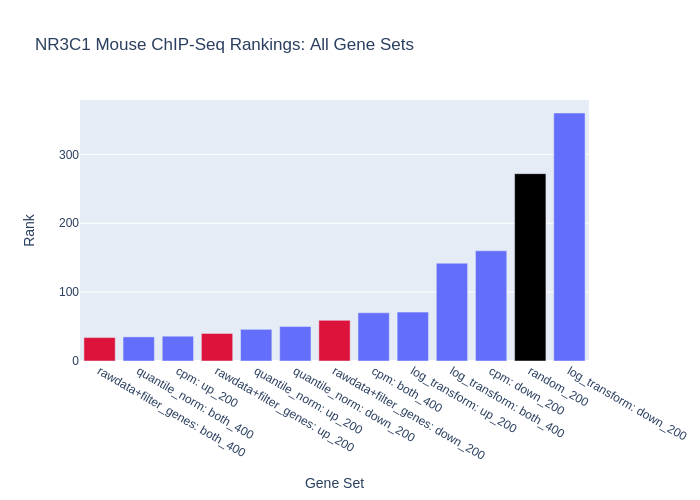

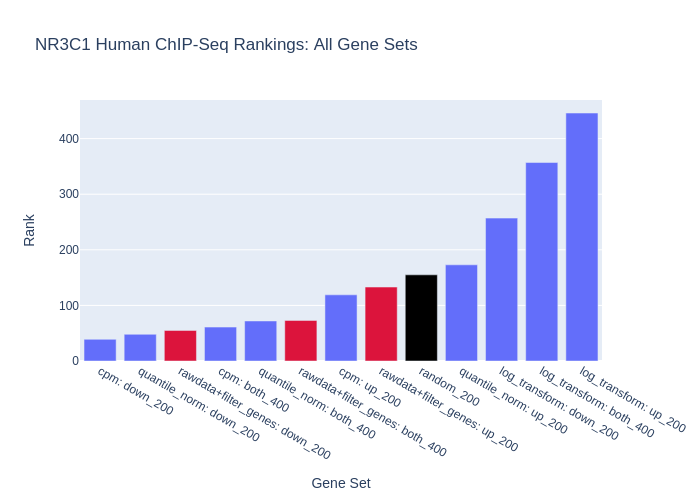

In [28]:
colors = ['#636EFA',] * 12
colors[0] = 'crimson'
colors[1] = 'crimson'
colors[2] = 'crimson'

fig1 = go.Figure()
fig1.add_trace(go.Bar(
    x=df[df['Name'] == "NR3C1 23031785 ChIP-Seq PC12 Mouse"]['Gene_Set'],
    y=df[df['Name'] == "NR3C1 23031785 ChIP-Seq PC12 Mouse"]['Rank'],
    name="Mouse", marker_color=colors))
fig1.update_layout(title_text='NR3C1 Mouse ChIP-Seq Rankings: All Gene Sets',
                   xaxis={'title':{'text':'Gene Set'}, 'categoryorder':'total ascending'}, 
                    yaxis={'title':{'text':'Rank'}})
fig1.show("png")

fig2=go.Figure()
fig2.add_trace(go.Bar(
    x=df[df['Name'] == "NR3C1 21868756 ChIP-Seq MCF10A Human"]['Gene_Set'],
    y=df[df['Name'] == "NR3C1 21868756 ChIP-Seq MCF10A Human"]['Rank'],
    name="Human", marker_color=colors))
fig2.update_layout(title_text='NR3C1 Human ChIP-Seq Rankings: All Gene Sets',
                xaxis={'title':{'text':'Gene Set'}, 'categoryorder':'total ascending'}, 
                yaxis={'title':{'text':'Rank'}})
fig2.show("png")

In [29]:
df_averages = df_averages.reset_index()

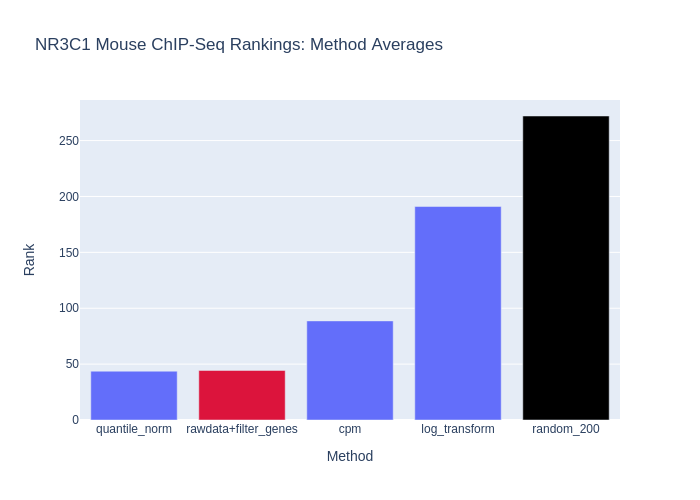

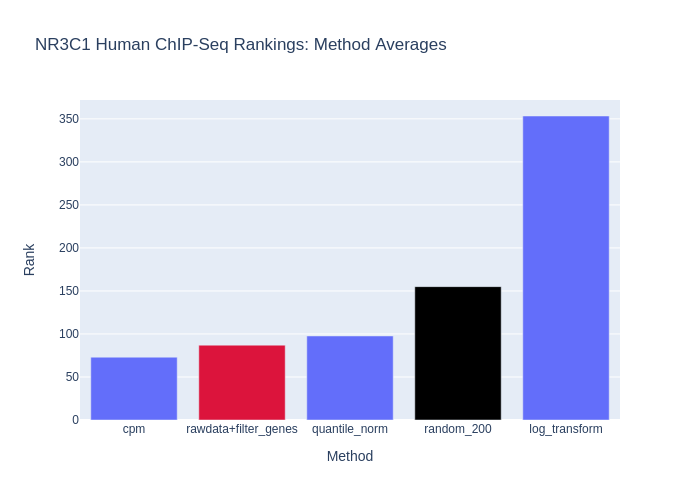

In [30]:
colors = ['#636EFA',] * 5
colors[1] = 'crimson'
colors[4] = 'black'

fig3 = go.Figure()
fig3.add_trace(go.Bar(
    x=df_averages[df_averages['Name'] == "NR3C1 23031785 ChIP-Seq PC12 Mouse"]['Method'],
    y=df_averages[df_averages['Name'] == "NR3C1 23031785 ChIP-Seq PC12 Mouse"]['Rank'],
    name="Mouse", marker_color=colors))
fig3.update_layout(title_text='NR3C1 Mouse ChIP-Seq Rankings: Method Averages',
                   xaxis={'title':{'text':'Method'}, 'categoryorder':'total ascending'}, 
                    yaxis={'title':{'text':'Rank'}})
fig3.show("png")

colors = ['#636EFA',] * 5
colors[1] = 'crimson'
colors[3] = 'black'

fig4=go.Figure()
fig4.add_trace(go.Bar(
    x=df_averages[df_averages['Name'] == "NR3C1 21868756 ChIP-Seq MCF10A Human"]['Method'],
    y=df_averages[df_averages['Name'] == "NR3C1 21868756 ChIP-Seq MCF10A Human"]['Rank'],
    name="Human", marker_color=colors))
fig4.update_layout(title_text='NR3C1 Human ChIP-Seq Rankings: Method Averages',
                xaxis={'title':{'text':'Method'}, 'categoryorder':'total ascending'}, 
                yaxis={'title':{'text':'Rank'}})
fig4.show("png")